# 2d Brownian oscillator example

Data generated by `oscill2d_sim.py`, with 400 bootstrap runs. These are statistics of exceedance probabilities $P(X > xthresh)$ for the maxima of individual independent runs, fit to a logistic **GEV** model.

These statistics are for the **position vector** not the velocity.

The raw output for correlation scenario `xx` is in the file with naming `oscillator_corxx.csv`. Each row represents the coordinate maxima for independent oscillator runs. The bootstrap multifidelity method is run in `oscillator.R`.

All CIs are at level $\alpha = 0.01$, meaning the confidence interval is given by the $0.005$ and $0.995$ empirical quantiles of a single bootstrapped run.

**Dependence parameter:**

In this case it is `cor`, the correlation between coordinates of the driving noise. This is renamed to `s` for compatibility with profiling code.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
d = pd.read_csv('data/oscillator_est.csv')
d = d.rename(columns = {'parid' : 'xthresh', 'cor': 's'})

In [3]:
d.describe()

runid       xthresh        qhf_05        qhf_95          q_05  \
count  33000.000000  33000.000000  3.300000e+04  33000.000000  33000.000000   
mean     150.500000      4.668980  8.797178e-02      0.364190      0.080211   
std       86.603371      0.876525  1.670814e-01      0.405578      0.152810   
min        1.000000      3.295751  1.387779e-16      0.000061      0.000000   
25%       75.750000      3.906075  2.020177e-07      0.013561      0.000000   
50%      150.500000      4.668980  1.381140e-03      0.140491      0.000000   
75%      225.250000      5.431885  8.175379e-02      0.673364      0.076158   
max      300.000000      6.042209  1.000000e+00      1.000000      1.000000   

               q_95             s  
count  33000.000000  33000.000000  
mean       0.383816     74.000000  
std        0.408830     15.811628  
min        0.000000     49.000000  
25%        0.017852     59.000000  
50%        0.159058     74.000000  
75%        0.999389     89.000000  
max        1.000000     99.000000

In [4]:
dtrue = pd.read_csv('data/oscillator_esttrue.csv').rename(columns = {'cor': 's'})

In [5]:
dtrue

xthresh   s    p_true
0    3.295751  49  0.544220
1    3.600913  49  0.269150
2    3.906075  49  0.109655
3    4.211237  49  0.038530
4    4.516399  49  0.012125
..        ...  ..       ...
105  4.821561  99  0.003475
106  5.126723  99  0.000930
107  5.431885  99  0.000280
108  5.737047  99  0.000090
109  6.042209  99  0.000000

[110 rows x 3 columns]

In [6]:
d = d.merge(dtrue, how = 'left', on = ['xthresh', 's'])
d.s = d.s/100

In [7]:
d.query('xthresh.isna() | s.isna()')

Empty DataFrame
Columns: [runid, xthresh, qhf_05, qhf_95, q_05, q_95, s, p_true]
Index: []

### Data transformations

Each data point here is an **independent run** of the bootstrapped procedure.

First, rename the columns and constrain the logged values to be in the allowed value range.

Assuming low CI bound leads with zero adn high leads with 9.

In [8]:
d.columns = d.columns.str.replace(r'q(hf)?_0\d+', 'q\g<1>low')
d.columns = d.columns.str.replace(r'q(hf)?_9\d+', 'q\g<1>high')

In [9]:
d = d.assign(ci_cover_hi = d.p_true.le(d.qhigh), 
             ci_cover_lo = d.p_true.ge(d.qlow), 
             ci_cover = lambda x: x.loc[:, 'ci_cover_hi':].all(axis = 1), 
             ci_width = d.qhigh - d.qlow,
             hfci_cover_hi = d.p_true.le(d.qhfhigh), 
             hfci_cover_lo = d.p_true.ge(d.qhflow), 
             hfci_cover = lambda x: x.loc[:, 'hfci_cover_hi':].all(axis = 1), 
             hfci_width = d.qhfhigh - d.qhflow)

## How well does the bootstrapped CI cover the true value?

Not well. The main takeaway I have here is that we need to optimize over the shape parameter in the GEV distribution family, rather than setting it to zero for the gumbel.

### Univariate: Summary
A summary across all `xthresh` values.

In [10]:
dcover = d.loc[:, ['s', 'xthresh', 'ci_cover', 'ci_width', 'hfci_cover', 'hfci_width']]
dcover = dcover.groupby(['s', 'xthresh']).agg('mean').reset_index()

In [11]:
dcover.describe()

s     xthresh    ci_cover    ci_width  hfci_cover  hfci_width
count  110.000000  110.000000  110.000000  110.000000  110.000000  110.000000
mean     0.740000    4.668980    0.916182    0.303605    0.879515    0.276218
std      0.158838    0.880523    0.058215    0.324287    0.136031    0.302803
min      0.490000    3.295751    0.830000    0.009443    0.000000    0.010893
25%      0.590000    3.906075    0.870000    0.044560    0.836667    0.033423
50%      0.740000    4.668980    0.886667    0.125183    0.870000    0.093783
75%      0.890000    5.431885    0.983333    0.641235    0.970000    0.581743
max      0.990000    6.042209    1.000000    0.903242    0.996667    0.843815

### Plots

#### CI coverage rates and widths across runs


In [12]:
dcover = dcover.melt(id_vars = ['s', 'xthresh'])

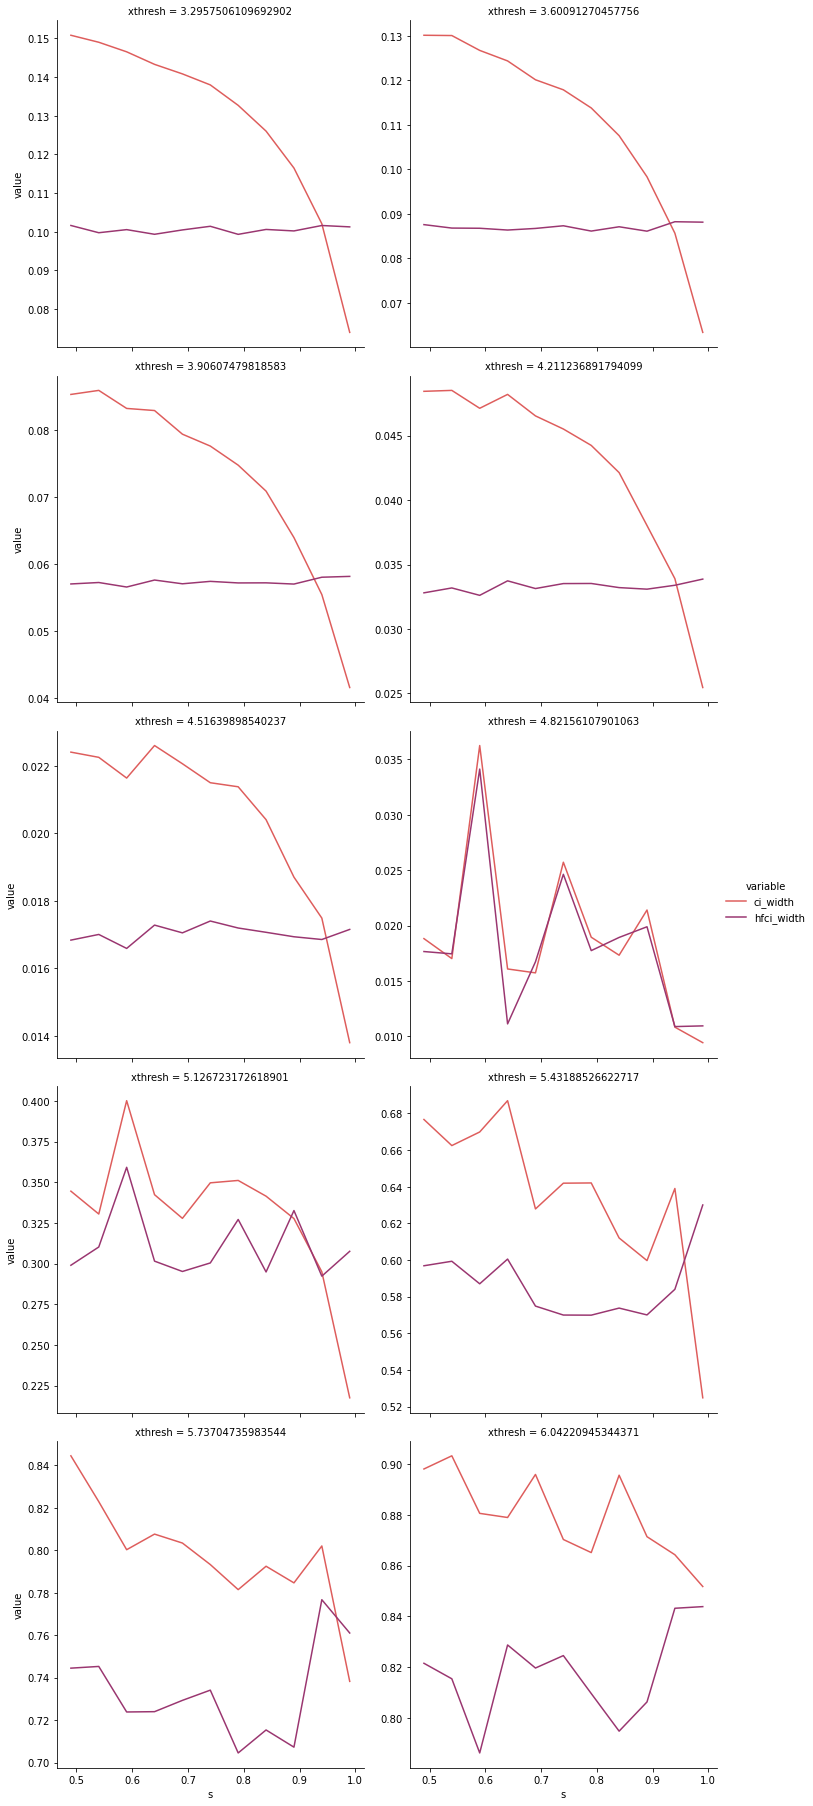

In [13]:
sns.relplot(data = dcover.loc[dcover.variable.str.match('(hf)?ci_width')],
            x = 's', y = 'value', kind = 'line',
            hue = 'variable', col = 'xthresh', col_wrap = 2,
            facet_kws = dict(sharey = False),
           palette = sns.color_palette("flare", n_colors = 2))

plt.show()

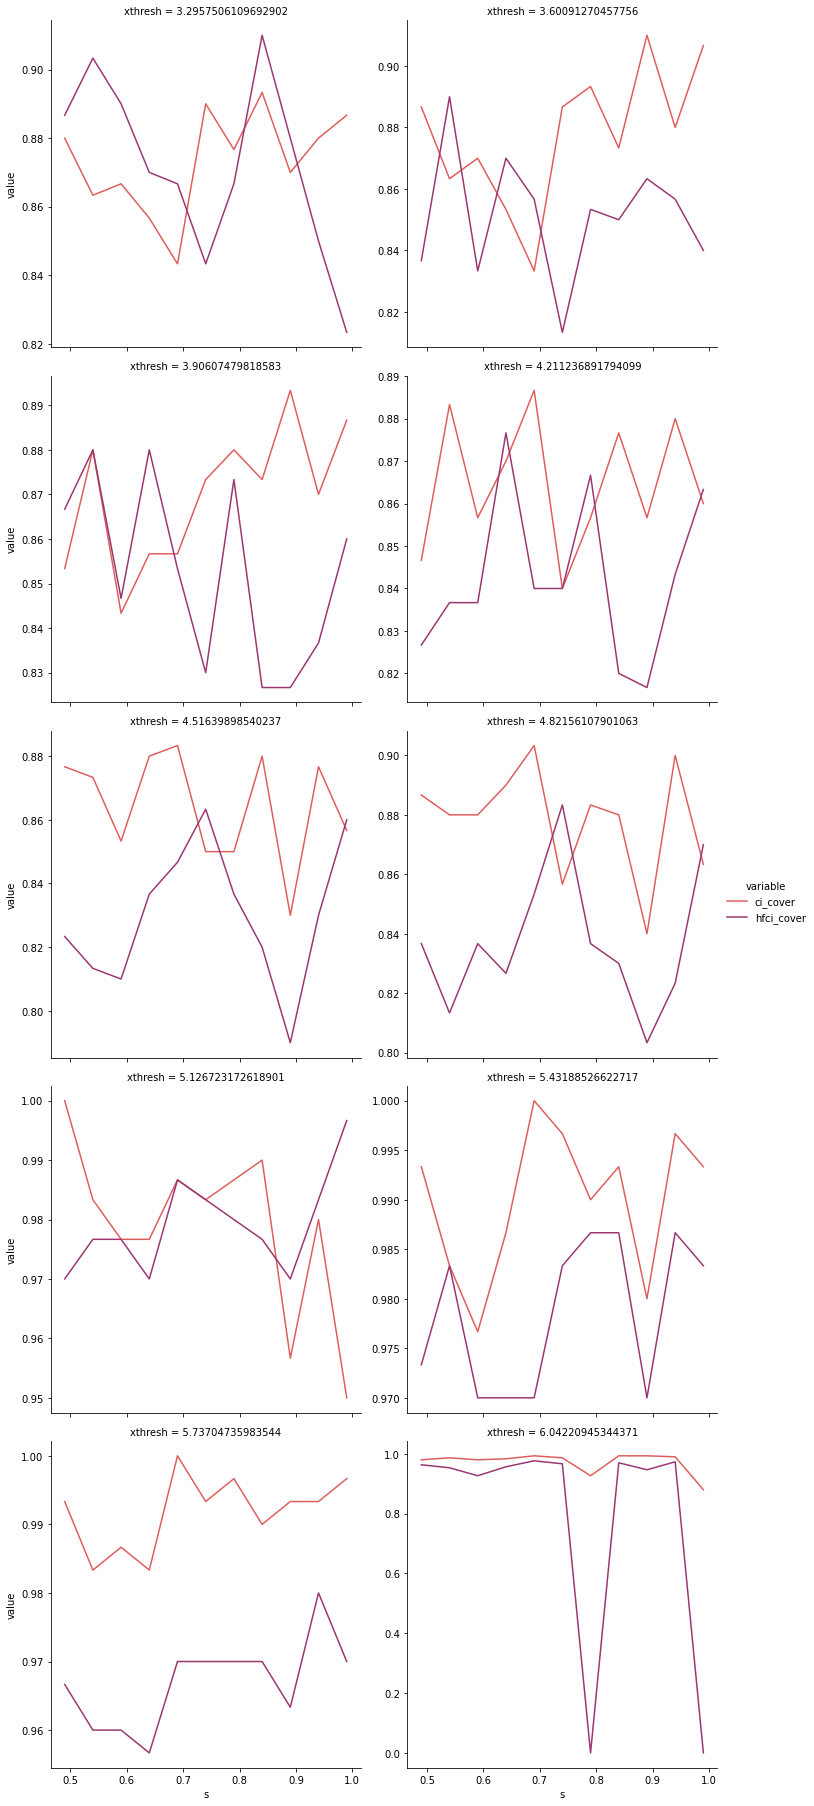

In [14]:
sns.relplot(data = dcover.loc[dcover.variable.str.match('(hf)?ci_cover')],
            x = 's', y = 'value', kind = 'line',
            hue = 'variable', col = 'xthresh', col_wrap = 2,
            facet_kws = dict(sharey = False),
           palette = sns.color_palette("flare", n_colors = 2))

plt.show()

### Another way to look at it
seaborn computes the mean values (in this case *of the quantile estimates*) for bootrapped resamples *of this dataset*. See [EstimateAggregator](https://github.com/mwaskom/seaborn/blob/master/seaborn/_statistics.py)

Error bars show these quantiles. Note the different y-axis scales.

See the closer look below.

In [15]:
d_long = d.loc[:, ['s', 'xthresh', 'runid', 'ci_cover', 'qlow', 'qhigh', 'p_true']]
d_long = d_long.melt(id_vars = ['s', 'xthresh', 'runid', 'ci_cover'])
d_long['xthresh'] = np.round(d_long['xthresh'], 2)

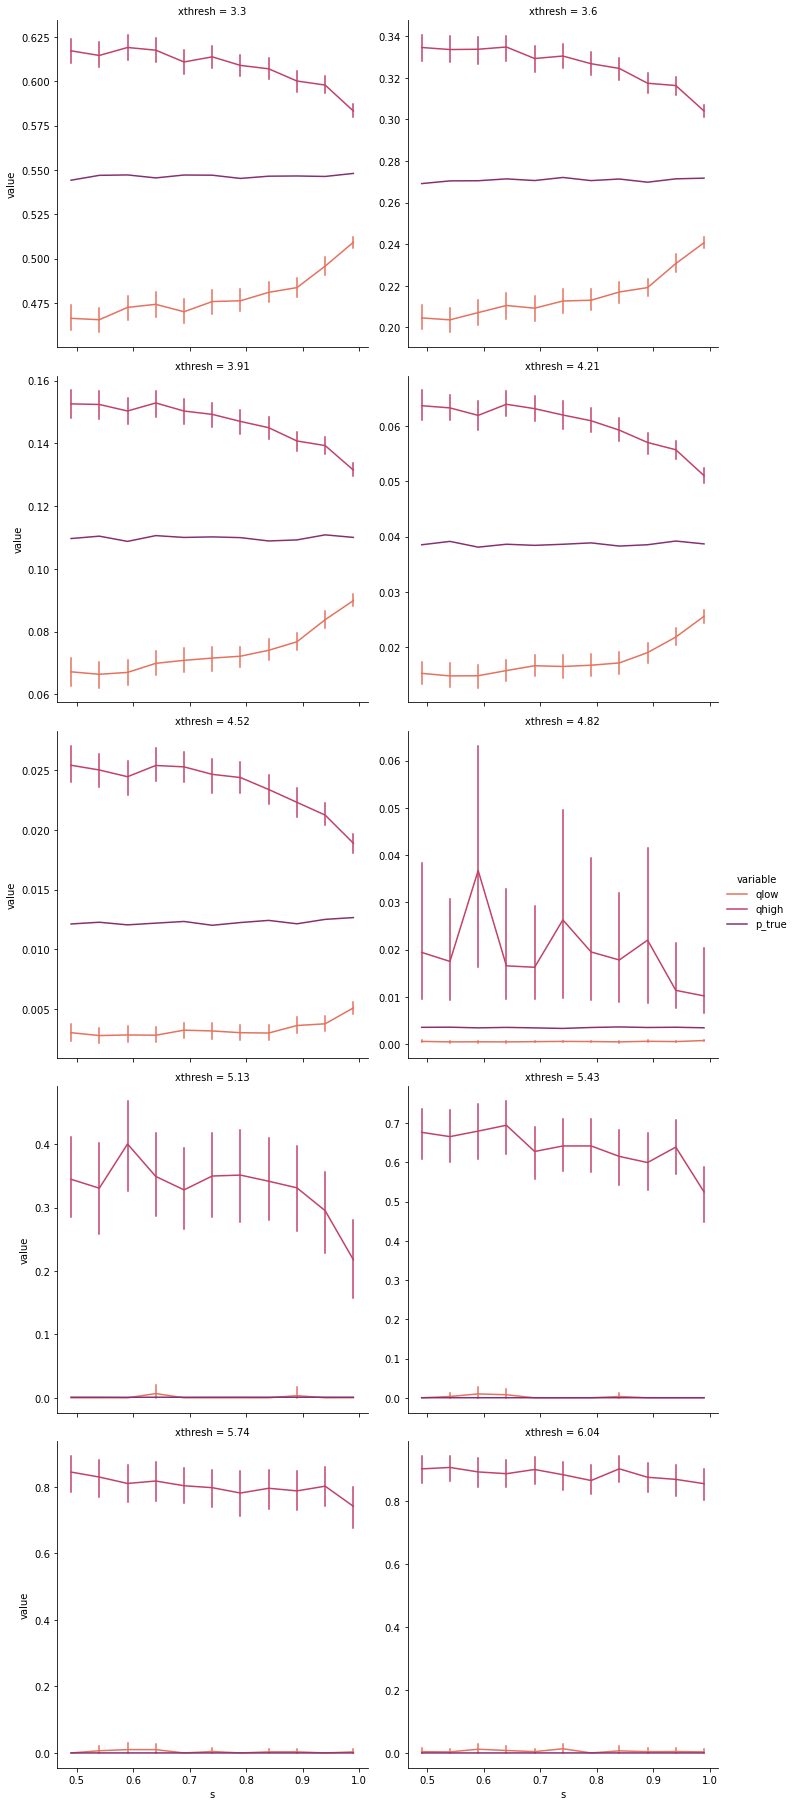

In [16]:
sns.relplot(data = d_long, col_wrap = 2, kind = 'line',
            x = 's', y = 'value', hue = 'variable', col = 'xthresh',
            ci = 99, err_style = 'bars',
            facet_kws = dict(sharey = False),
            palette = sns.color_palette("flare", n_colors = 3))
plt.show()

## A more detailed look
Interim results from this process output to csv for `cor = 89`.

For the position vector.

In [17]:
djoint = pd.read_csv('data/oscillator_m_joint_detail.csv')
dlofi = pd.read_csv('data/oscillator_m_lofi_detail.csv')

### Joint: Summary of parameter estimates
Across all bootstraps and runs.

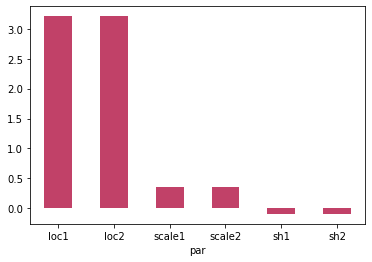

In [18]:
djoint.loc[:, ['par', 'mle']
          ].groupby('par').agg('mean').mle.plot(kind = 'bar', 
                                                color = sns.color_palette("flare", n_colors = 1),
                                                rot = 0)

plt.show()

Across bootstraps.

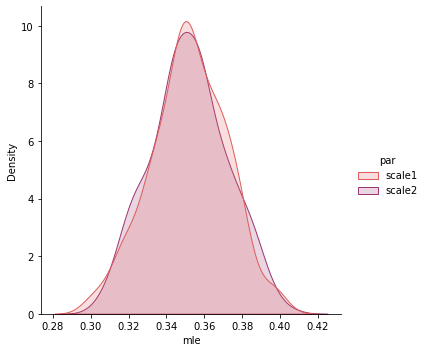

In [19]:
sns.displot(data = djoint.loc[djoint.par.isin(['scale1', 'scale2']), ['par', 'mle', 'runid']
          ].groupby(['par', 'runid']).agg('mean').reset_index('par'),
            kind = 'kde', hue = 'par', x = 'mle',
            palette = 'flare', fill = True, alpha = .2)

plt.show()

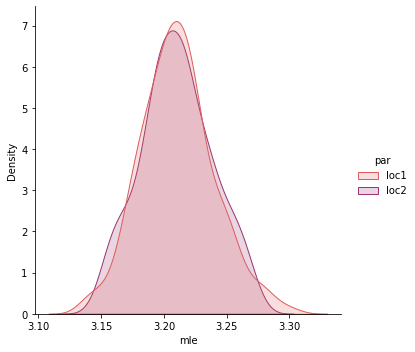

In [20]:
sns.displot(data = djoint.loc[djoint.par.isin(['loc1', 'loc2']), ['par', 'mle', 'runid']
          ].groupby(['par', 'runid']).agg('mean').reset_index('par'),
            kind = 'kde', hue = 'par', x = 'mle',
            palette = 'flare', fill = True, alpha = .2)

plt.show()

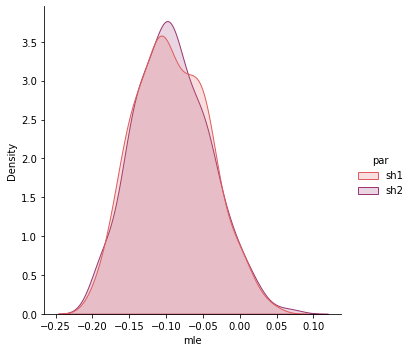

In [21]:
sns.displot(data = djoint.loc[djoint.par.isin(['sh1', 'sh2']), ['par', 'mle', 'runid']
          ].groupby(['par', 'runid']).agg('mean').reset_index('par'),
            kind = 'kde', hue = 'par', x = 'mle',
            palette = 'flare', fill = True, alpha = .2)

plt.show()

### lofi: Summary of parameter estimates
Across all bootstraps and runs.

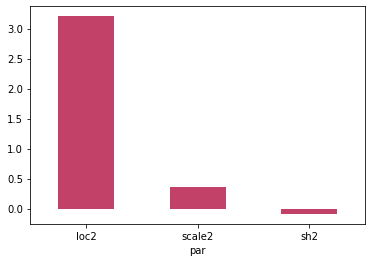

In [22]:
dlofi.loc[:, ['par', 'mle']
          ].groupby('par').agg('mean').mle.plot(kind = 'bar', 
                                                color = sns.color_palette("flare", n_colors = 1),
                                                rot = 0)

plt.show()

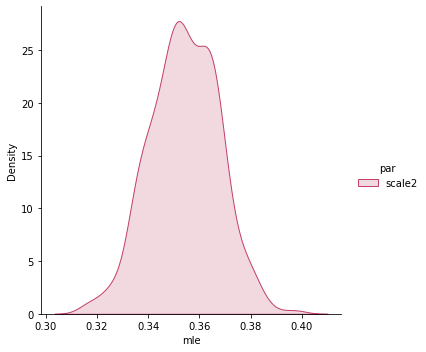

In [23]:
sns.displot(data = dlofi.loc[dlofi.par.eq('scale2'), ['par', 'mle', 'runid']
          ].groupby(['par', 'runid']).agg('mean').reset_index('par'),
            kind = 'kde', hue = 'par', x = 'mle',
            palette = 'flare', fill = True, alpha = .2)

plt.show()

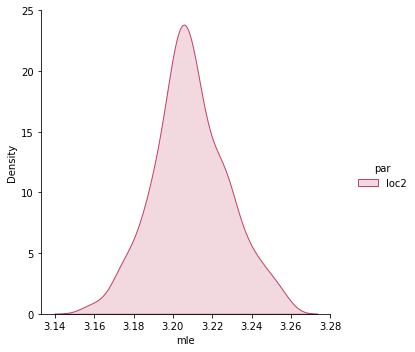

In [24]:
sns.displot(data = dlofi.loc[dlofi.par.eq('loc2'), ['par', 'mle', 'runid']
          ].groupby(['par', 'runid']).agg('mean').reset_index('par'),
            kind = 'kde', hue = 'par', x = 'mle',
            palette = 'flare', fill = True, alpha = .2)

plt.show()

Across bootstraps only.

### A more detailed look

In [25]:
dtrue_det = pd.read_csv('data/oscillator_esttrue_detail.csv')
dpoint = pd.read_csv('data/oscillator_pointest_detail.csv')

In [26]:
def _dpoint_prep(dpoint, dtrue):
    dpoint = dpoint.rename(columns = {'parid': 'xthresh'})
    dpoint = dpoint.merge(dtrue, how = 'left', on = 'xthresh')
    dpoint.xthresh = dpoint.xthresh.round(2)
    
    # if sluggish remove p_true and rejoin since constant for each xthresh
    dpoint_sum = dpoint.loc[:, ['xthresh', 'phat_mf', 'p_true', 'runid']
                       ].groupby(['xthresh', 'runid']
                                ).agg(qhigh = ('phat_mf', lambda x: x.quantile(0.995)),
                                      qlow = ('phat_mf', lambda x: x.quantile(0.005)),
                                      p_true = ('p_true', lambda x: x.iloc[0])
                                      ).reset_index('xthresh')
     
    return dpoint_sum

#### qlow: .005 quantile across bootstrap runs

The problem is our exceedance probability estimates are too large.

In [27]:
def compare_box(dpoint, dtrue, qvar = 'qlow', 
                xlow = None, xhigh = None, **kwargs):
    """data is as from oscillator_pointest_detail.csv
    kwargs passed to boxplot"""
    
    dpoint_sum = _dpoint_prep(dpoint, dtrue)
    
    if xlow is None:
        xlow = dpoint_sum.xthresh.min()
    if xhigh is None:
        xhigh = dpoint_sum.xthresh.max()
    
    dpoint_sum = dpoint_sum.loc[dpoint_sum.xthresh.ge(xlow) & dpoint_sum.xthresh.le(xhigh)]
    
    # for overplotting p_true
    dpoint_sum.xthresh = dpoint_sum.xthresh.astype(str)
    
    plt.subplots(figsize = (12, 10))
    sns.boxplot(data = dpoint_sum, x = 'xthresh', y = qvar, 
                palette = 'flare', **kwargs)
    sns.scatterplot(data = dpoint_sum, x = 'xthresh', y = 'p_true', 
                color = '#BEDB39', legend = False, s = 100)

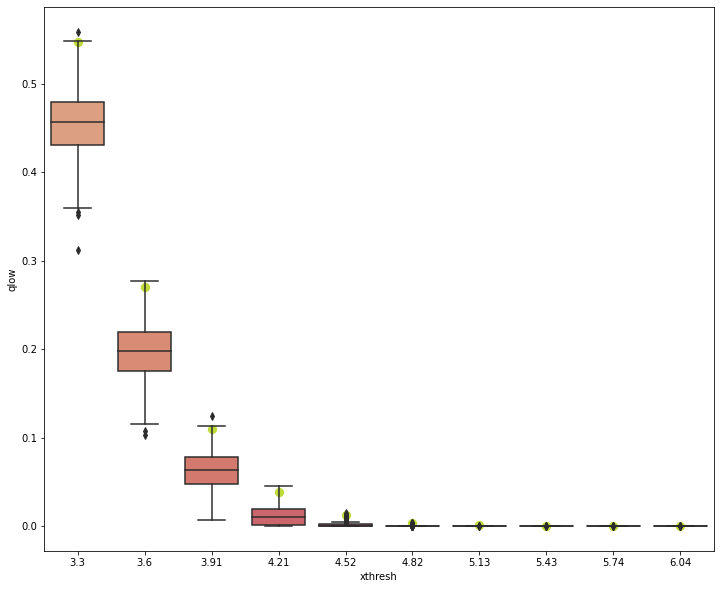

In [28]:
compare_box(dpoint, dtrue_det)

plt.show()

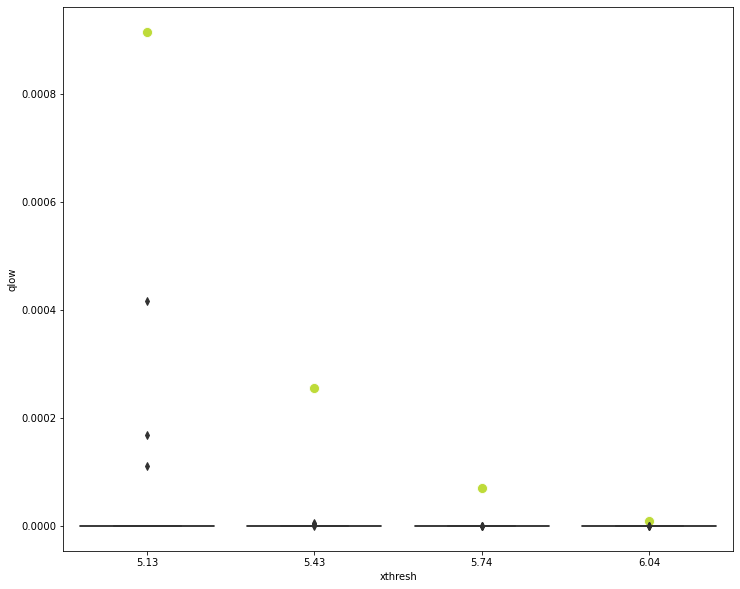

In [29]:
compare_box(dpoint, dtrue_det, xlow = 5)

plt.show()

#### Comparing the marginal empirical distribution with a GEV


In [30]:
dall = pd.read_csv('data/oscillator_cor89.csv')

Comparing to a GEV density with parameters at the median values from the bootstrap.

In [31]:
pars = djoint.loc[:, ['par', 'mle']
          ].groupby(['par']).agg('mean').loc[['loc1', 'scale1', 'sh1'], 'mle']

pars

par
loc1      3.208775
scale1    0.350869
sh1      -0.092802
Name: mle, dtype: float64

In [32]:
gev = stats.genextreme(c = pars['sh1'], loc = pars['loc1'], scale = pars['scale1'])

In [33]:
dall['gevrv'] = gev.rvs(dall.shape[0])

In [34]:
dall = dall.loc[:, ['x0', 'gevrv']].melt()

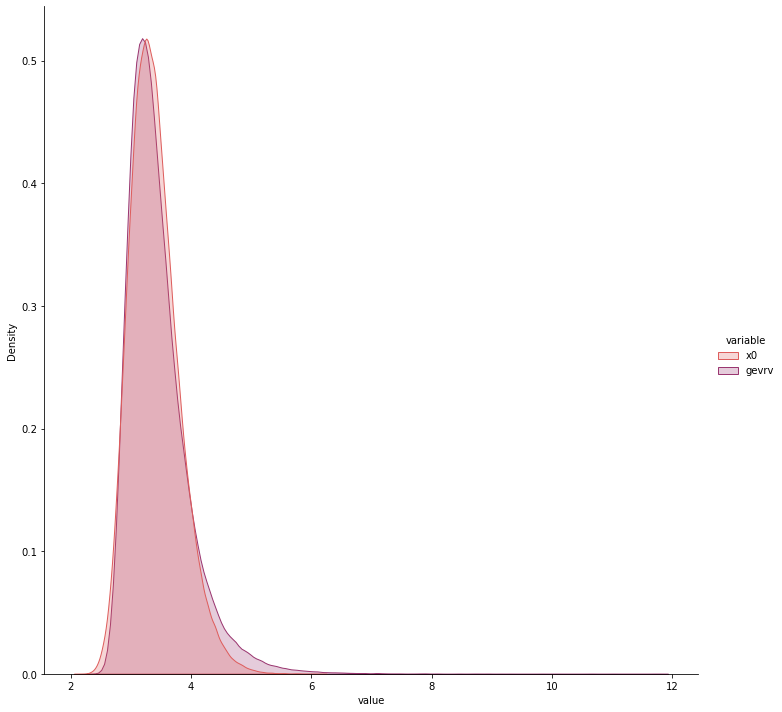

In [35]:
sns.displot(data = dall, kind = 'kde',
            x = 'value', hue = 'variable', fill = True, palette = 'flare',
            height = 10)

plt.show()

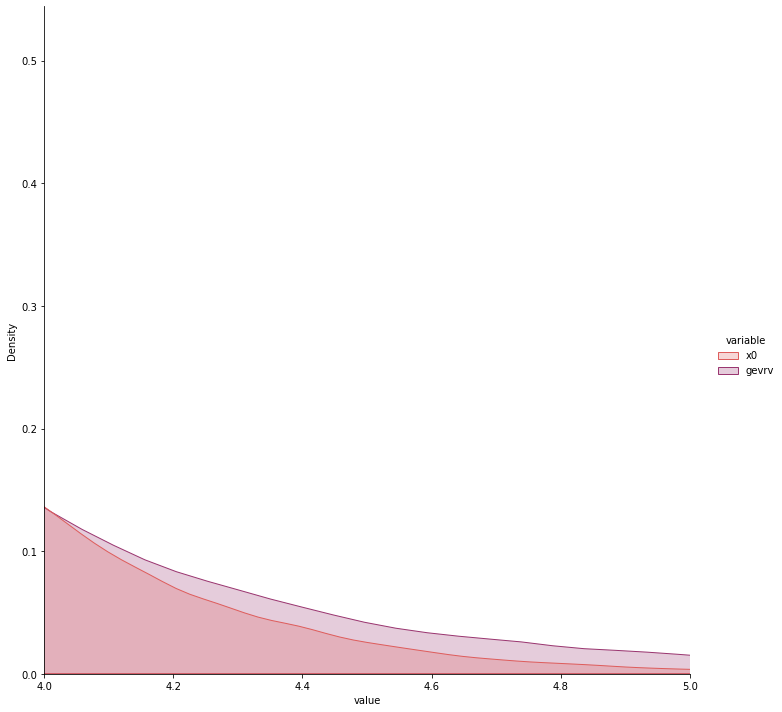

In [36]:
sns.displot(data = dall, kind = 'kde',
            x = 'value', hue = 'variable', fill = True, palette = 'flare',
            height = 10, facet_kws = dict(xlim = (4, 5)))

plt.show()

### Comments

From the theory, you know that the oscillator block max does indeed converge to a gumbel. But it does so in log time and therefore we are unlikely to get a good fit with a Gumbel.

Although the GEV model, by allowing a negative shape parameter, could in theory provide a better fit, non-smoothness of the loglikelihood near the support boundary `1 + sh*(x-loc)/scale = 0` appears to present numerical problems. At present here and in the R packages POT, evd and extRemes, this issue is handled very crudely. 

The R packages listed quietly set the objective function to some large-ish value in case of out-of-bounds errors: `1e6` or `1e10`. POT does so within a threshold of the boundary. In fact, this is their general approach to handling issues related to likelihood degeneracy --- for example dependence parameter values close to 0 for the bivariate GEV model with logistic dependence function.

In this work, there are two approaches, both of which are still crude: 

1. Out-of-support values return Inf for the objective function. This produces an error in optim, which is captured as parameter estimates NaN and those estimates are dropped from the bootstrap calculations. In other words, sampled datasets producing out of bounds errors are removed. This is of course not ideal and makes calculations extremely sensitive to parameter bounds supplied to the L-BFGS-B algorithm.

2. The boundary constraint is softened by using `softmax(1+z)` instead of `1+z` directly, where `softmax(x) = eps * log1p(x/eps)` for a smallish positive value `eps`. This function is always strictly positive for real `x` and converges to `max(x, 0)` as `eps` goes to zero. The optim function still is wrapped to capture errors as NaN parameter estimates, which are then dropped from bootstrap estimates, but these will occur much much less frequently than in option 1. The `eps` parameter would ideally be tuned: When `eps = 1e-3` already `softmax(-1)` is numerically zero so estimates for data with such values will be `NaN`. We have not yet fully explored or researched the consequences of this for the MLE estimates, but practically speaking I suspect it is not too dissimilar from simply fixing the value of the objective when data are out of the support as the R packages named above do. 

A better approach would likely be to use a smoothing method or to reformulate the problem via augmented Lagrangian methods, as is suggested in the now-defunct R package [climex](https://github.com/theGreatWhiteShark/climex). Optimization is not a focus of this project, but it does seem that fitting methods for GEV models could use an update.